# Traffic Sign Classifier

## Imports

In [1]:
import math
import os
import pickle
import time
from textwrap import wrap

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

%matplotlib inline

tf.set_random_seed(1234)

## Step 0: Load The Data

In [2]:
# Load pickled data
training_file = '../../IPython/09_Traffic_Sign_Classifier/train.p'
validation_file = '../../IPython/09_Traffic_Sign_Classifier/valid.p'
testing_file = '../../IPython/09_Traffic_Sign_Classifier/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
# get a dictionary whose keys are the sign id's and whose values are the sign names
with open('../../IPython/09_Traffic_Sign_Classifier/signnames.csv', 'r') as f:
    sign_name_dict = dict(line.strip().split(',') for line in f.readlines()[1:])

In [5]:
# get a list `signs_by_id_*` where `signs_by_id_*[i]` is a list of all signs with id `i` in set *
signs_by_id_train = [[ind for ind, sign_id in enumerate(y_train) if sign_id == i] for i in range(n_classes)]
signs_by_id_valid = [[ind for ind, sign_id in enumerate(y_valid) if sign_id == i] for i in range(n_classes)]
signs_by_id_test = [[ind for ind, sign_id in enumerate(y_test) if sign_id == i] for i in range(n_classes)]

In [6]:
# get a list `sign_examples` where `sign_examples[i]` is an example of sign type `i`
sign_examples = [None] * n_classes

for i in range(n_classes):
    j = 0
    while np.mean(X_train[signs_by_id_train[i][j], :, :, :]) < 64. and j < len(signs_by_id_train[i]) - 1:
        j += 1
    sign_examples[i] = X_train[signs_by_id_train[i][j], :, :, :]

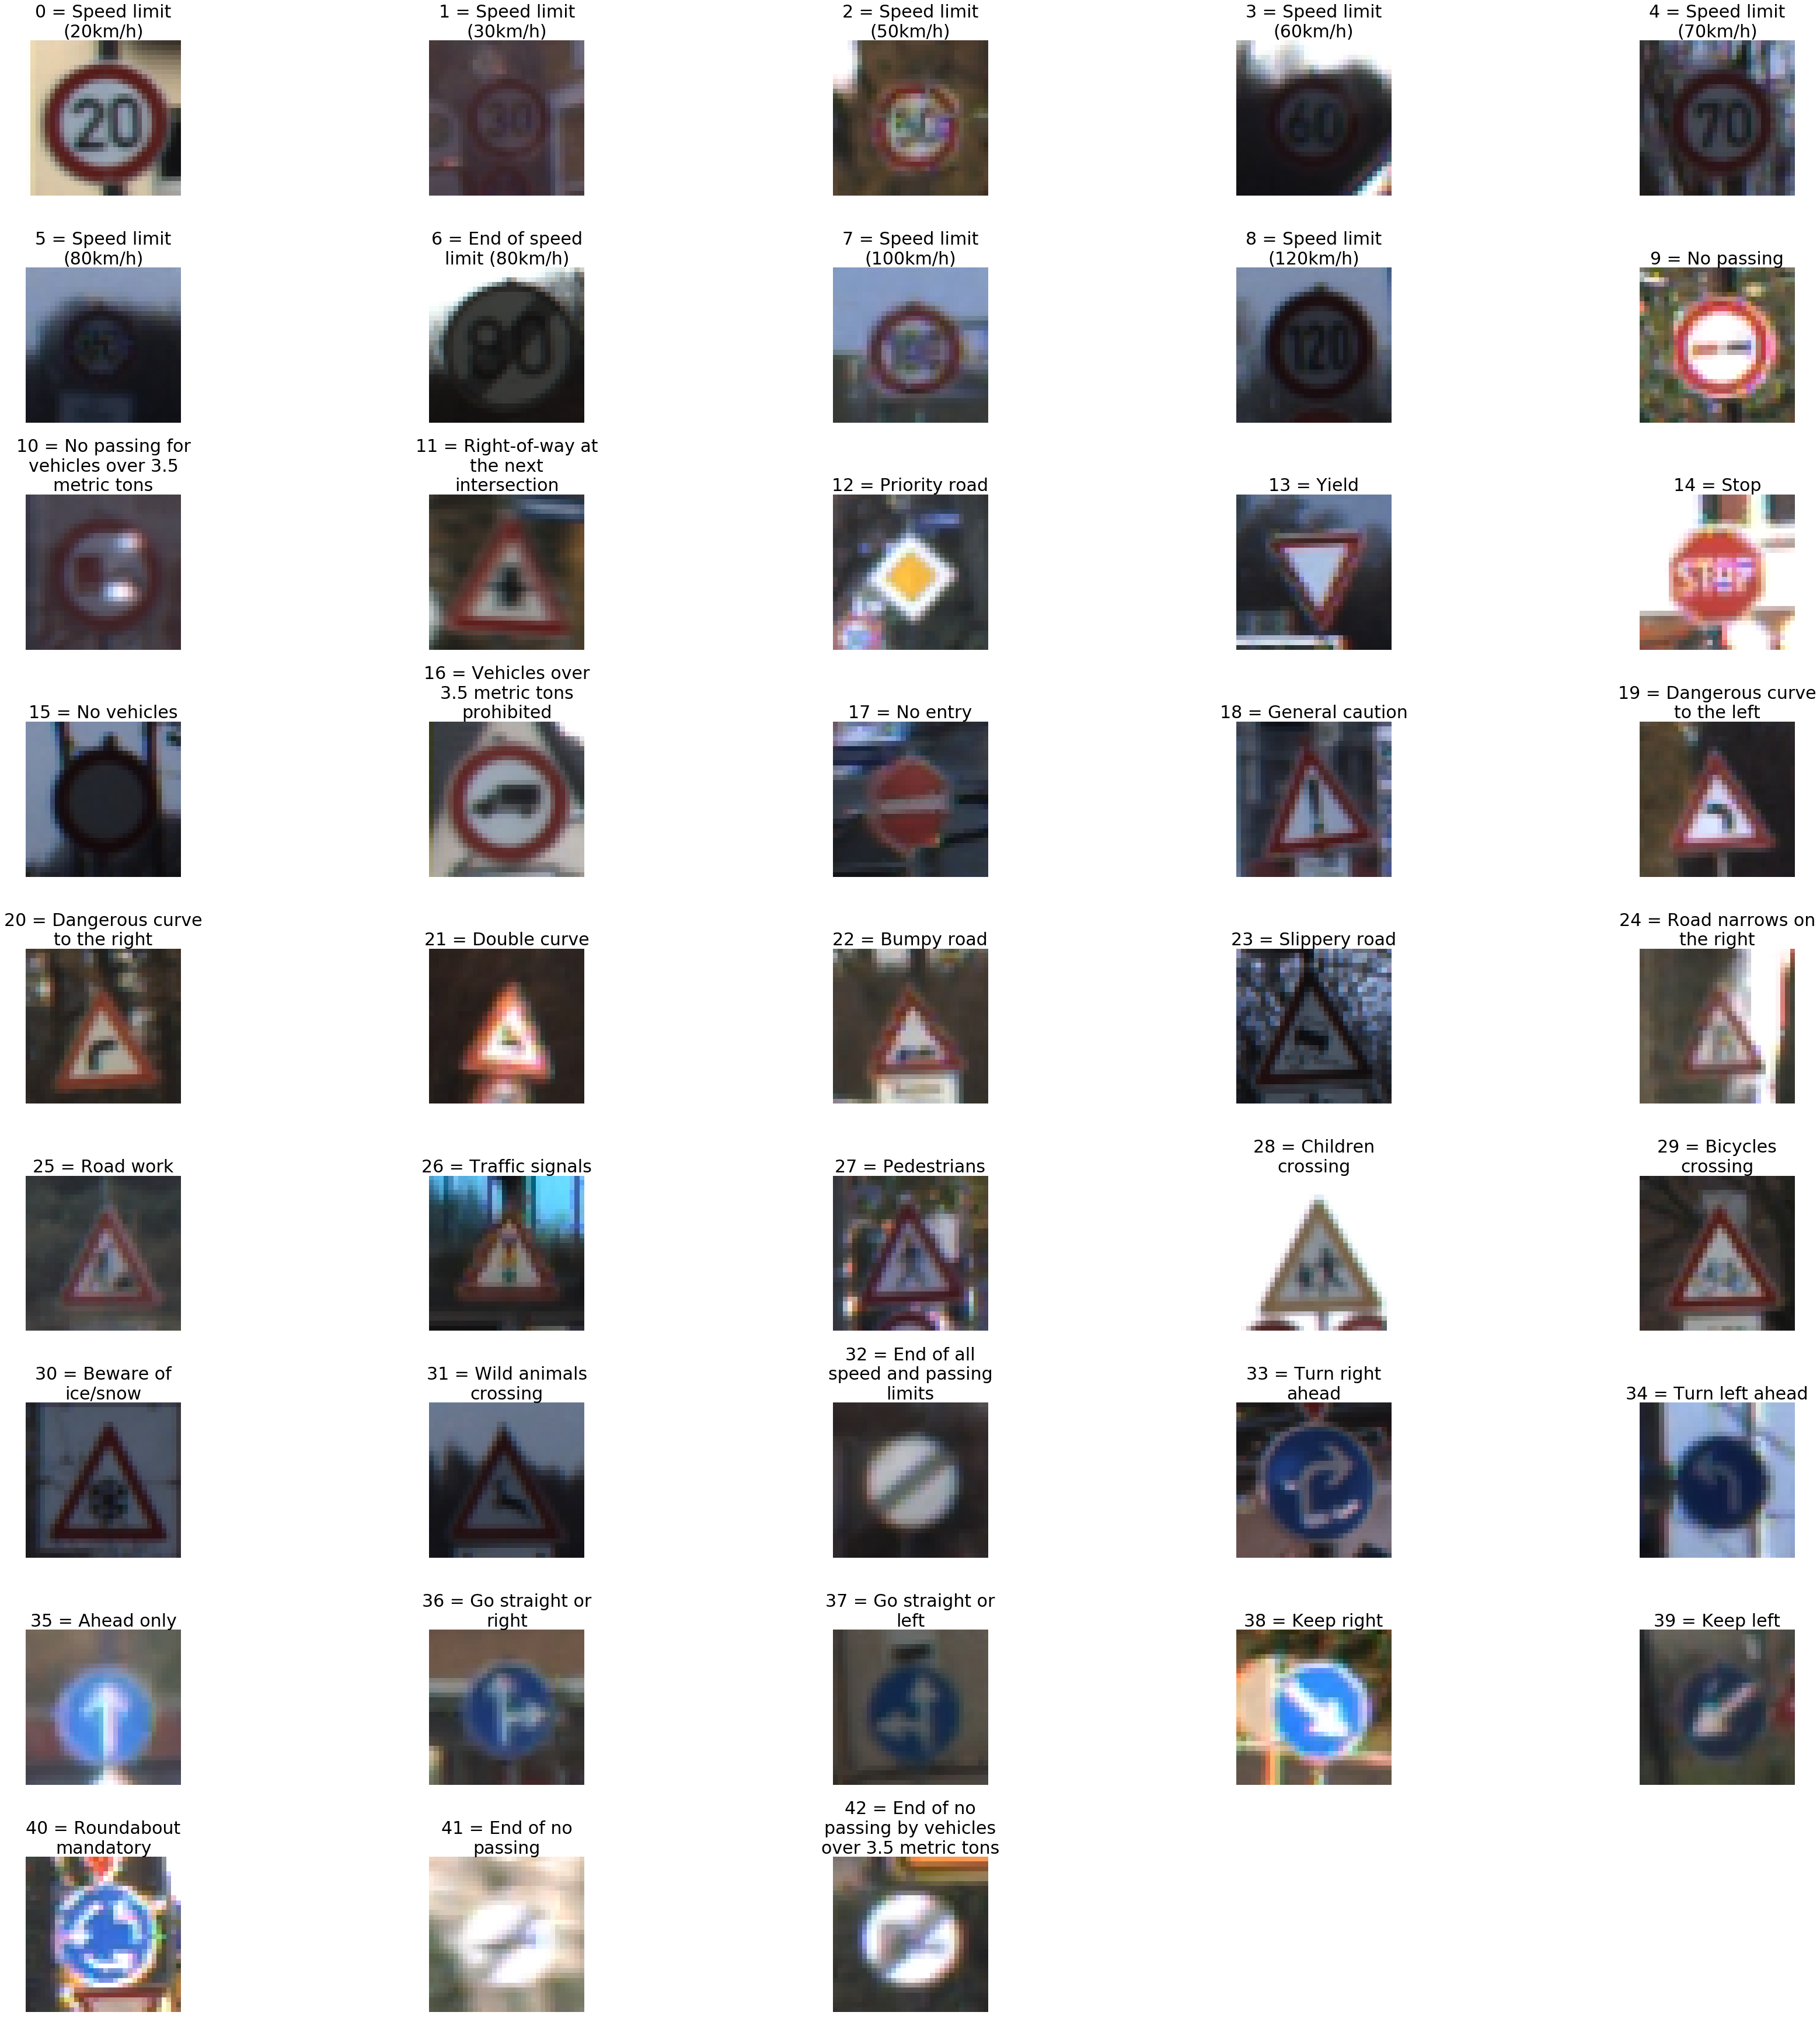

In [7]:
# plot an example of each sign type
rows = 9
cols = 5

plt.figure(1, figsize=(48,48))
for i in range(43):
    plt.subplot(rows, cols, i+1)
    plt.title("\n".join(wrap('{0} = {1}'.format(i, sign_name_dict[str(i)]), 20)), fontsize=30)
    plt.imshow(sign_examples[i])
    plt.axis('off')
    
plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

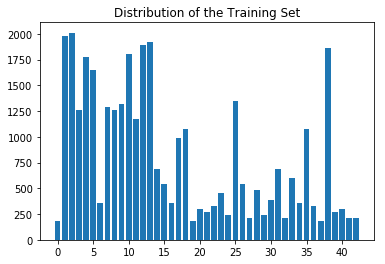

In [8]:
plt.bar(range(n_classes), [len(s) for s in signs_by_id_train], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Training Set')
plt.show()

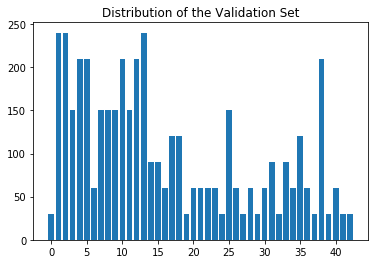

In [9]:
plt.bar(range(n_classes), [len(s) for s in signs_by_id_valid], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Validation Set')
plt.show()

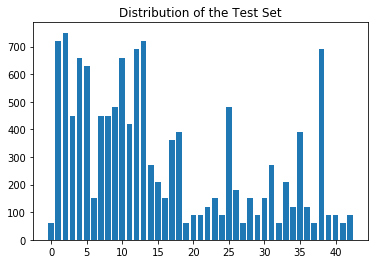

In [10]:
plt.bar(range(n_classes), [len(s) for s in signs_by_id_test], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Test Set')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
def preprocess(img):
    """Standardize an image using ``(pixel - 128.) / 128.`` for each of the channels (RGB)
    
    Parameters
    ----------
    img : numpy.ndarray
        the image (width x height x channels)
        
    Returns
    -------
    numpy.ndarray
        the preprocessed image
    
    """
    return (img - 128.) / 128.

In [12]:
X_train = np.array([preprocess(img) for img in X_train])
X_valid = np.array([preprocess(img) for img in X_valid])
X_test = np.array([preprocess(img) for img in X_test])

### Model Architecture

In [13]:
def forward_pass(x):
    """Perform a forward pass through the network
    
    Parameters
    ----------
    x : Tensor
        the input data
        
    Returns
    -------
    Tensor
        the logits
        
    """
    # Arguments used for tf.truncated_normal --> used to randomly define the weights and biases
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    w1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    h1 = tf.nn.conv2d(x, w1, strides, padding) + b1

    # Activation.
    a1 = tf.nn.dropout(tf.nn.relu(h1), keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'SAME'
    a2 = tf.nn.dropout(tf.nn.max_pool(a1, ksize, strides, padding), keep_prob)
    

    # Layer 2: Convolutional. Output = 10x10x16.
    w3 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(16))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    h3 = tf.nn.conv2d(a2, w3, strides, padding) + b3

    # Activation.
    a3 = tf.nn.dropout(tf.nn.relu(h3), keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'SAME'
    a4 = tf.nn.dropout(tf.nn.max_pool(a3, ksize, strides, padding), keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    a5 = flatten(a4)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w6 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b6 = tf.Variable(tf.zeros(120))
    h6 = tf.add(tf.matmul(a5, w6), b6)

    # Activation.
    a6 = tf.nn.dropout(tf.nn.relu(h6), keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w7 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b7 = tf.Variable(tf.zeros(84))
    h7 = tf.add(tf.matmul(a6, w7), b7)

    # Activation.
    a7 = tf.nn.dropout(tf.nn.relu(h7), keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w8 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b8 = tf.Variable(tf.zeros(43))

    return tf.add(tf.matmul(a7, w8), b8)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### TensorFlow Variables

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

#### Hyperparameters

In [15]:
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

#### Tensors

In [16]:
logits = forward_pass(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [17]:
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [18]:
def evaluate(X_data, y_data):
    """Calculate the accuracy of the model
    
    Parameters
    ----------
    X_data : Tensor
        the input data
    y_data : Tensor
        the labels for the input data
        
    Returns
    -------
    float
        the accuracy of the model
    
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the model

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic-signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.737

EPOCH 2 ...
Validation Accuracy = 0.870

EPOCH 3 ...
Validation Accuracy = 0.894

EPOCH 4 ...
Validation Accuracy = 0.906

EPOCH 5 ...
Validation Accuracy = 0.925

EPOCH 6 ...
Validation Accuracy = 0.933

EPOCH 7 ...
Validation Accuracy = 0.936

EPOCH 8 ...
Validation Accuracy = 0.929

EPOCH 9 ...
Validation Accuracy = 0.937

EPOCH 10 ...
Validation Accuracy = 0.943

EPOCH 11 ...
Validation Accuracy = 0.951

EPOCH 12 ...
Validation Accuracy = 0.935

EPOCH 13 ...
Validation Accuracy = 0.941

EPOCH 14 ...
Validation Accuracy = 0.942

EPOCH 15 ...
Validation Accuracy = 0.949

EPOCH 16 ...
Validation Accuracy = 0.949

EPOCH 17 ...
Validation Accuracy = 0.939

EPOCH 18 ...
Validation Accuracy = 0.941

EPOCH 19 ...
Validation Accuracy = 0.948

EPOCH 20 ...
Validation Accuracy = 0.940

EPOCH 21 ...
Validation Accuracy = 0.943

EPOCH 22 ...
Validation Accuracy = 0.946

EPOCH 23 ...
Validation Accuracy = 0.954

EPOCH 24 ...
Validation Accura

#### Validation and Test Set Accuracy

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("\n  Training set accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation set accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))
    print("      Test set accuracy = {:.3f}".format(evaluate(X_test, y_test)))

INFO:tensorflow:Restoring parameters from ./traffic-signs

  Training set accuracy = 1.000
Validation set accuracy = 0.956
      Test set accuracy = 0.948


## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

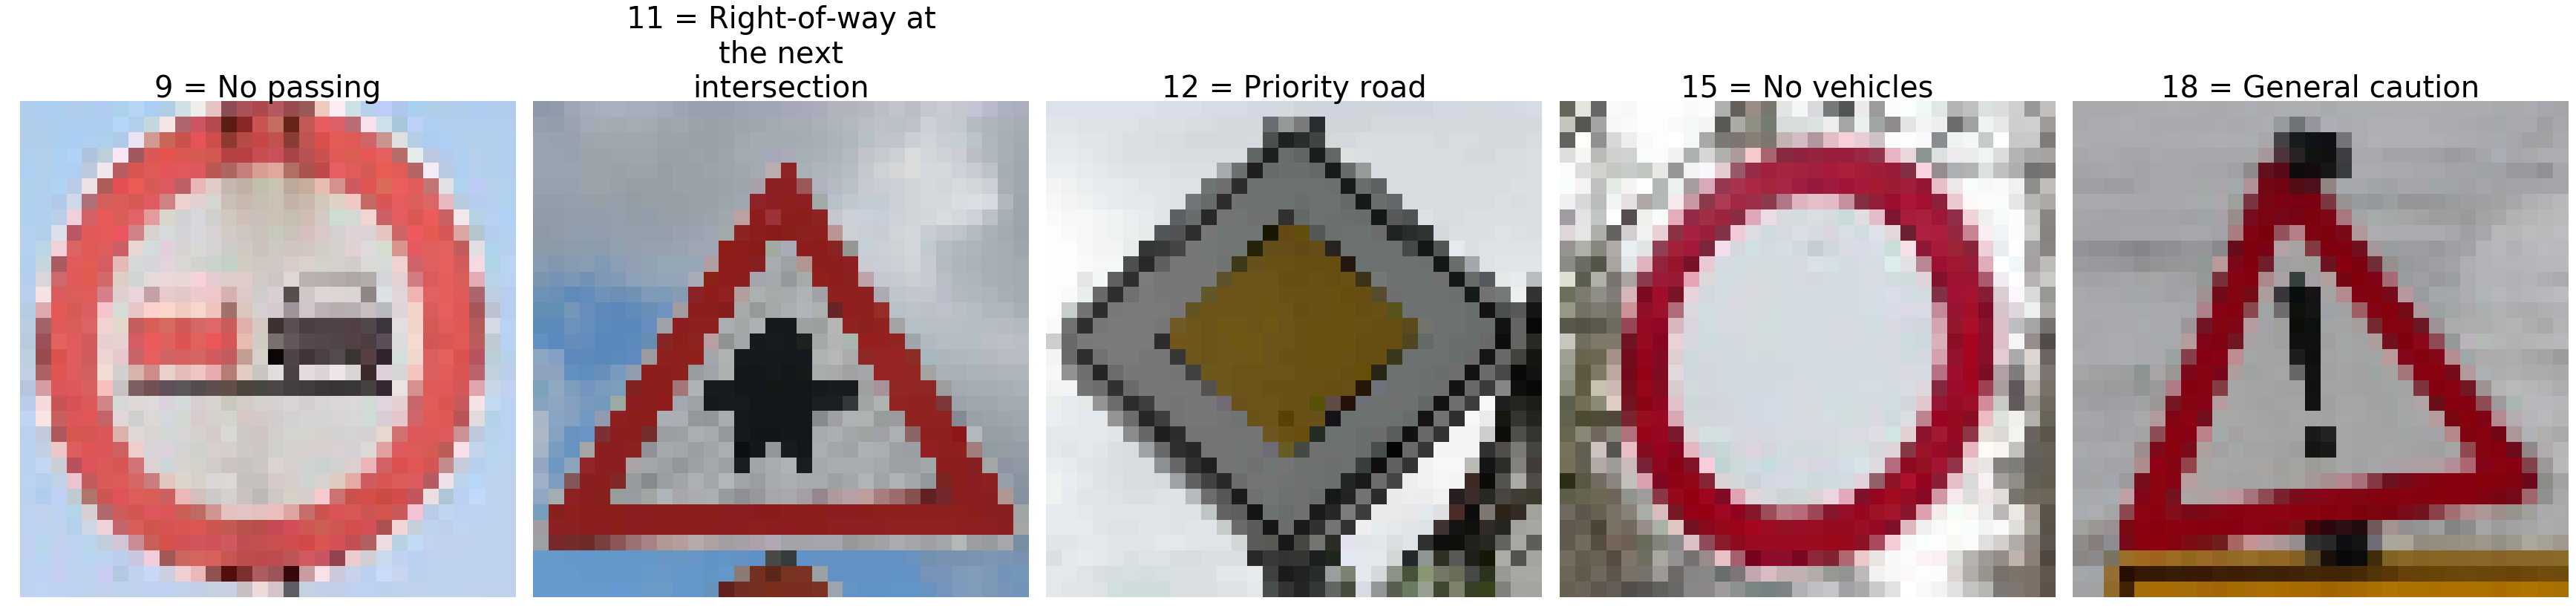

In [21]:
test_image_dir = '../../IPython/09_Traffic_Sign_Classifier/test_images/'

# sort the images by their type
test_images = sorted(os.listdir(test_image_dir), key=lambda img: int(img.split('_')[0]))

# extract the image types from their filenames
y_new = np.array([int(img.split('_')[0]) for img in test_images])

# load the images
X_new0 = np.array([cv2.resize(plt.imread(test_image_dir + img), (32, 32)) for img in test_images])

# pre-process the images
X_new = np.array([preprocess(img) for img in X_new0])

# plot the images
plt.figure(1, figsize=(48,48))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title("\n".join(wrap('{0} = {1}'.format(y_new[i], sign_name_dict[str(y_new[i])]), 20)), fontsize=40)
    plt.imshow(X_new0[i, :, :, :])
    plt.axis('off')
    
plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)

### Predict the Sign Type for Each Image

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: X_new, keep_prob: 1.0})
    
print('\nPrediction   Ground Truth')
print('----------   ------------')    
for p_i, y_i in zip(predictions, y_new):
    print('    {0:2d}            {1:2d}     '.format(p_i, y_i))

INFO:tensorflow:Restoring parameters from ./traffic-signs

Prediction   Ground Truth
----------   ------------
     9             9     
    11            11     
    12            12     
    15            15     
    18            18     


### Analyze Performance

In [23]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    new_accuracy = evaluate(X_new, y_new)
    print("\nNew Accuracy = {:.3f}".format(new_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic-signs

New Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). 

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    softmaxes = sess.run(tf.nn.softmax(logits), feed_dict={x: X_new, keep_prob: 1.0})
    
    values, indices = sess.run(tf.nn.top_k(softmaxes, k=5))
    
np.set_printoptions(precision=5)
print('\n' + str(values))

INFO:tensorflow:Restoring parameters from ./traffic-signs

[[  1.00000e+00   5.13824e-08   4.68345e-09   9.60071e-12   5.32794e-12]
 [  1.00000e+00   4.96308e-08   1.35513e-15   6.64222e-17   2.89836e-18]
 [  1.00000e+00   5.01552e-13   1.34005e-15   5.75203e-16   4.50225e-16]
 [  1.00000e+00   4.86539e-14   3.33460e-14   1.75175e-14   6.74197e-15]
 [  1.00000e+00   1.40208e-10   9.01703e-12   3.54147e-13   2.16338e-14]]


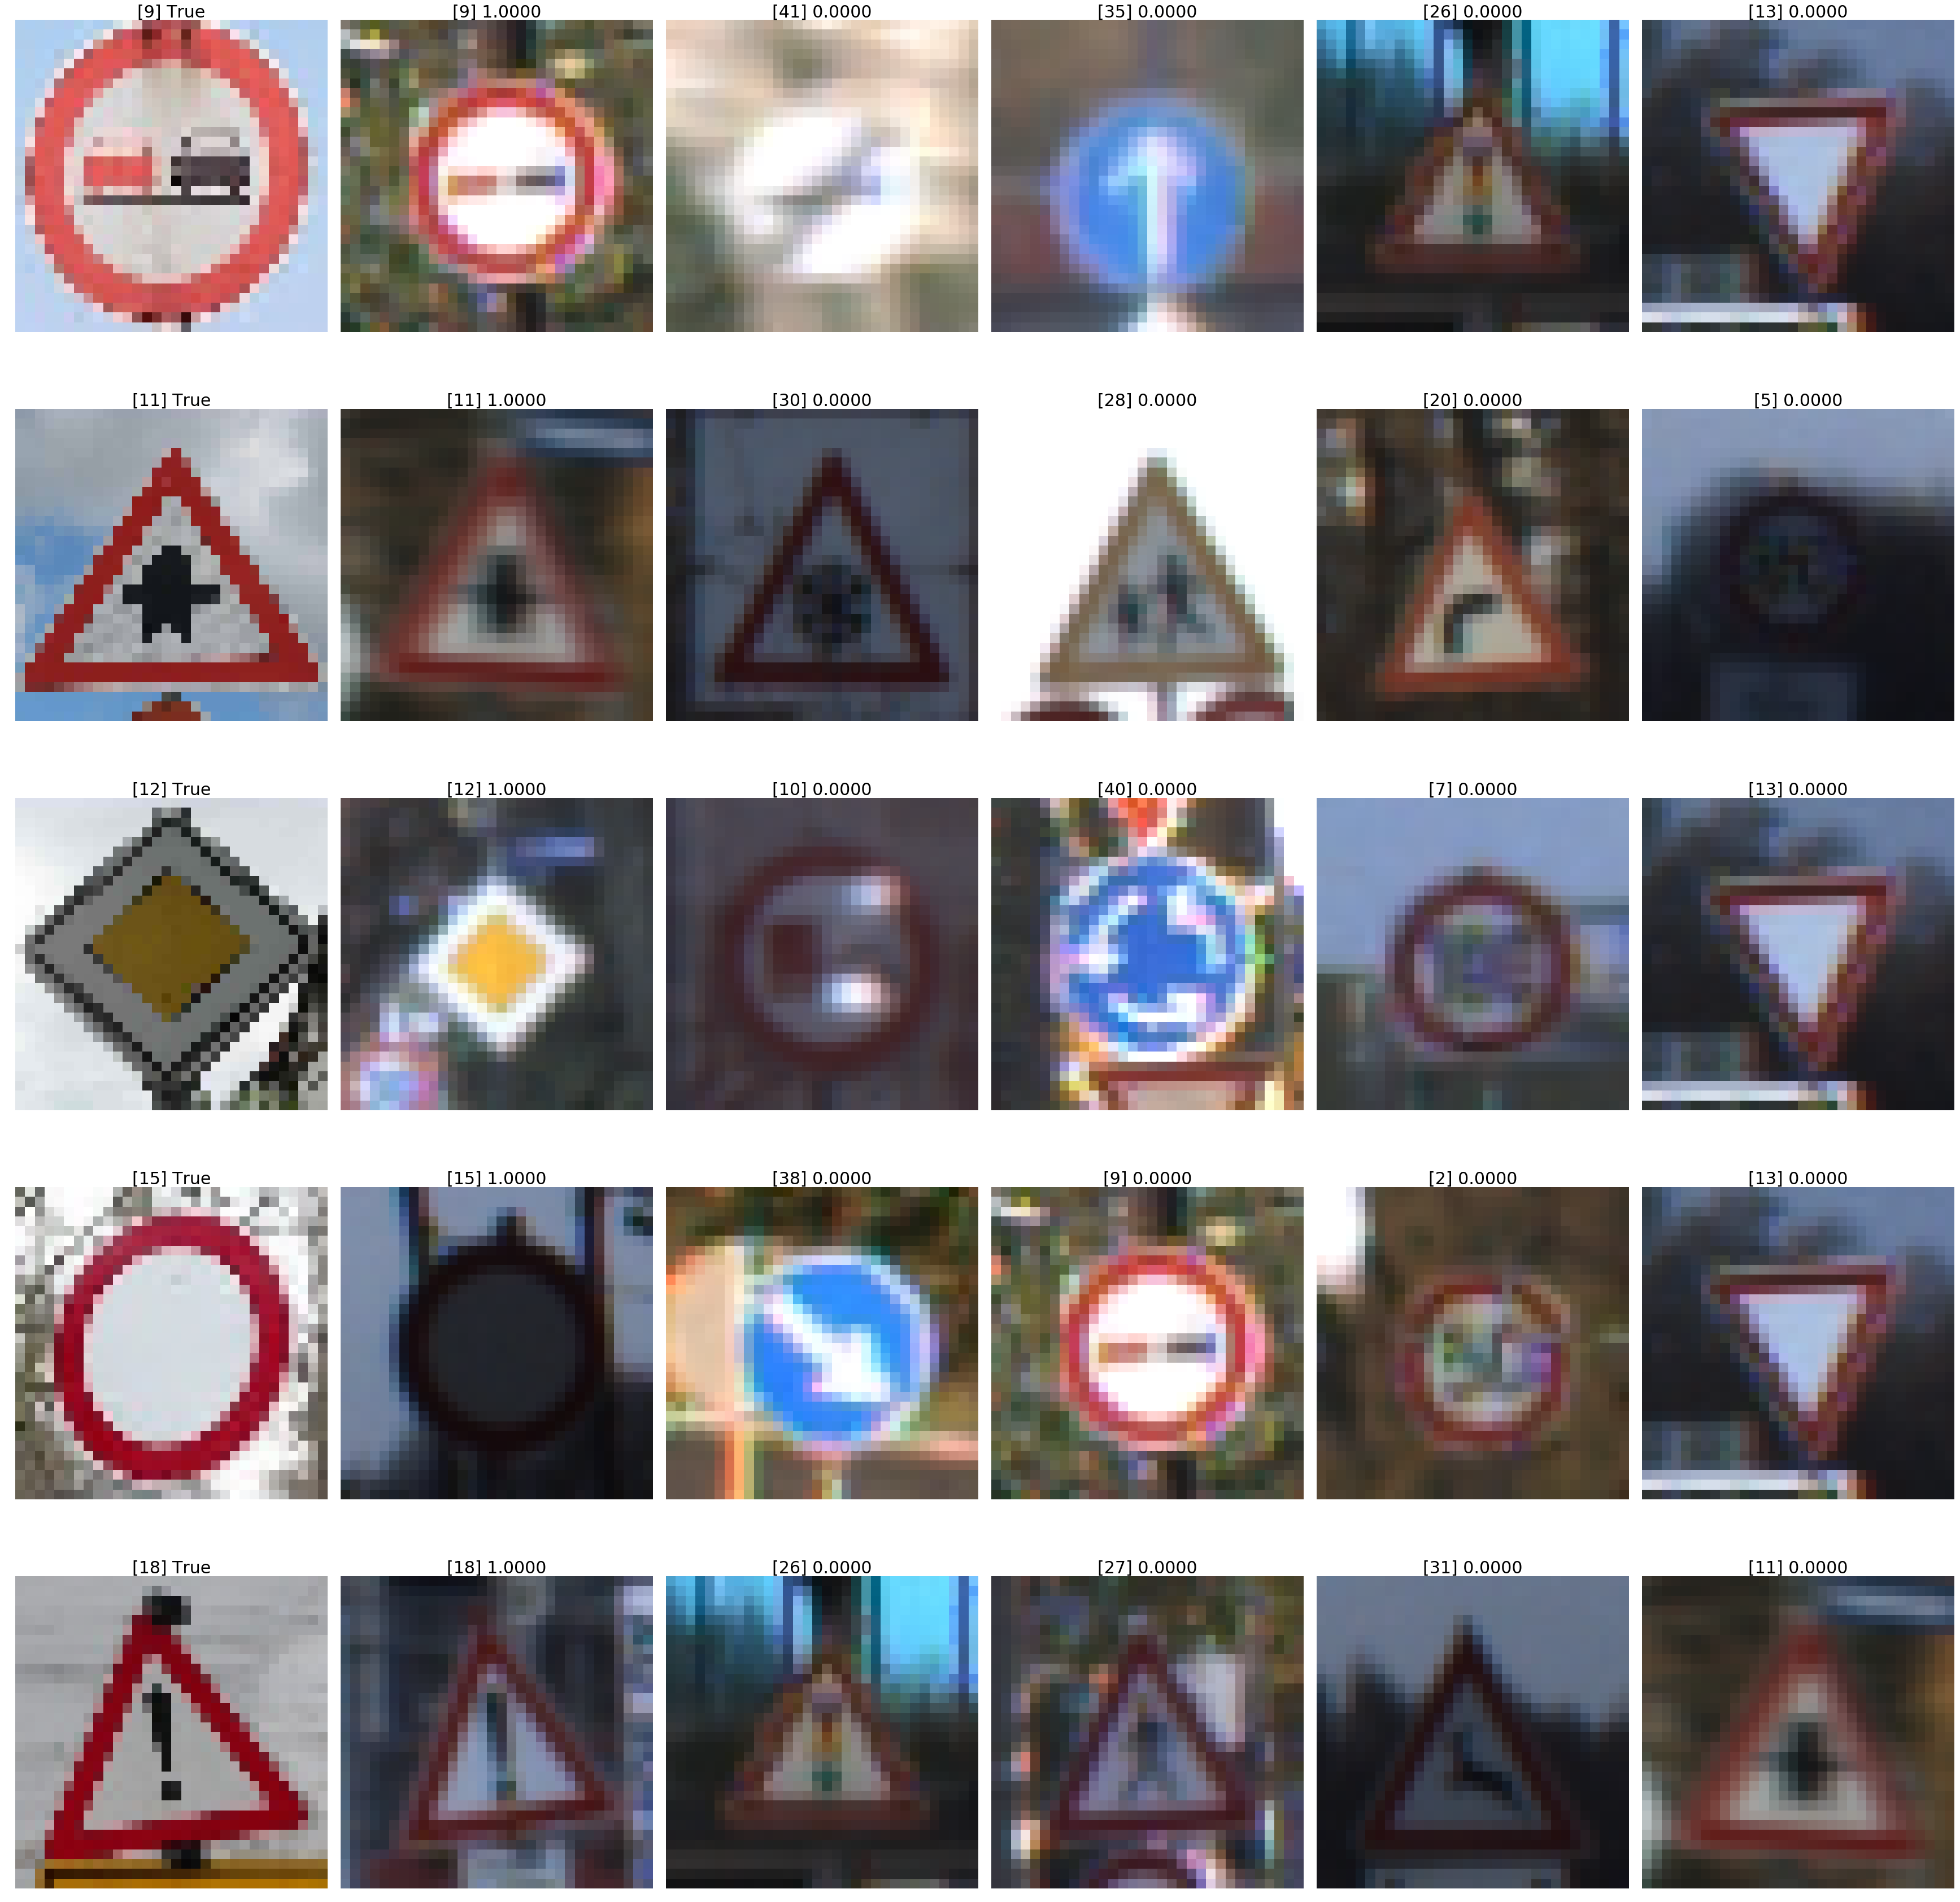

In [25]:
rows, cols = values.shape
cols += 1

plt.figure(1, figsize=(48,48))
for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, row*cols + col + 1)
        if col == 0:
            plt.title("[{0}] True".format(y_new[row]), fontsize=30)
            plt.imshow(X_new0[row, :, :, :])
        else:
            plt.title("[{0}] {1:.4f}".format(indices[row, col-1], values[row, col-1]), fontsize=30)  
            plt.imshow(sign_examples[indices[row, col-1]])
            
        plt.axis('off')
    
plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)